(120, 2)


AttributeError: 'list' object has no attribute 'reshape'

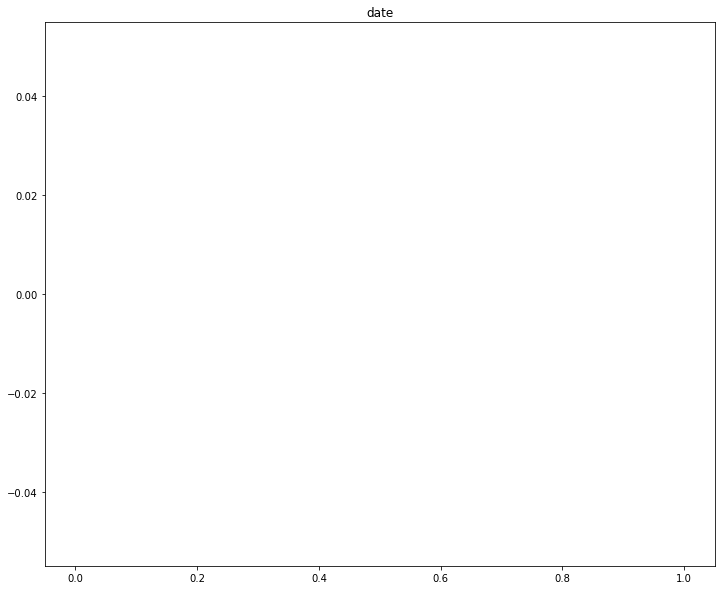

In [7]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import *
import sklearn.linear_model
import sklearn.preprocessing
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

def convert_datelist_counterlist(list_date):
    liste = []
    cpt = 0
    for date in list_date:
        liste.append(cpt)
        cpt = cpt+1
    return liste

filename = "dmarketPrices.csv"
names = ['prix', 'date']
dataset = pd.read_csv(filename, delim_whitespace=True, names=names)

# analyses sommaires
print(dataset.shape)

# on consulte les types des données:
dataset.dtypes

# aperçu des stats de chaque colonne
pd.set_option('precision', 1)
dataset.describe()

# histograms
dataset.hist(bins=10,figsize=(12,10),grid=False);

# on calcule les corréaltions entre colonnes (coeff. de correlation de Pearson)
pd.set_option('precision', 2)
dataset.corr(method='pearson')

# Setting X and Y axis
x = convert_datelist_counterlist(dataset['date'].values)
y = dataset['prix'].values

# Train / Validation / Test split (60%/20%/20%)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=8) # 0.25 x 0.8 = 0.2


alpha_values = range(150, 251, 1)
alpha_values

scores =[]
for alpha in alpha_values:
    # alpha est fixé (comme mu=mu0)
    monModele = sklearn.linear_model.Ridge(alpha=alpha)
    
    # je converge theta vers theta^*
    monModele.fit(X_train.reshape(-1,1), Y_train) # avoir une liste numpy des jours convertis en nombres (on veut notamment l'écart des jours)
    
    score = monModele.score(X_val, Y_val)
    scores.append(score)
    print(alpha, score, monModele.score(X_train, Y_train))

plt.plot(alpha_values, scores)
alpha_etoile = np.argmax(np.array(scores))

monModele = sklearn.linear_model.Ridge(alpha=alpha_etoile)
monModele.fit(X_train, Y_train)
monModele.score(X_train, Y_train), monModele.score(X_val, Y_val), monModele.score(X_test, Y_test)

Y_train_pred = monModele.predict(X_train)
print("train error", sklearn.metrics.mean_squared_error(Y_train_pred, Y_train))

Y_test_pred = monModele.predict(X_test)
print("test error", sklearn.metrics.mean_squared_error(Y_test_pred, Y_test))

